In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



import cooler
import bioframe

import cooltools
import cooltools.expected
from cooltools import snipping

import cooltools.lib.plotting
# Set up parallelization
import multiprocess

from matplotlib.colors import LogNorm
from matplotlib.ticker import EngFormatter
bp_formatter = EngFormatter('b')
from scipy import interpolate
from mpl_toolkits.axes_grid import make_axes_locatable
import pyBigWig
import csv

from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
from cooltools.insulation import calculate_insulation_score, find_boundaries

import cooltools.eigdecomp
import cooltools.saddle
from scipy.stats import pearsonr
from scipy import linalg
from scipy.signal import argrelextrema
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import itertools
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
import warnings

<ipython-input-1-dad355c1584a>:23: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid import make_axes_locatable


In [2]:
def format_ticks(ax, x=True, y=True, rotate=True):
    if y:
        ax.yaxis.set_major_formatter(bp_formatter)
    if x:
        ax.xaxis.set_major_formatter(bp_formatter)
        ax.xaxis.tick_bottom()
    if rotate:
        ax.tick_params(axis='x',rotation=45)

In [3]:
chromHMM_D = bioframe.read_table('/home/kimj50/cohesin_paper/_notebook_v1/output/chromHMM/Daugherty/Supplemental_Table_S10.txt',schema='bed4')
chromHMM_E = bioframe.read_table('/home/kimj50/cohesin_paper/_notebook_v1/output/chromHMM/Evans/pnas.1608162113.sd01.txt',schema='bed4')
jets = bioframe.read_table('/home/kimj50/cohesin_paper/jets_call/jetcall_v5_w30kb.bed',schema='bed4')


jets['chrom'] = 'chr'+jets['chrom']
jets['start'] = jets['start']+1000
jets['end'] = jets['end']-999
jets

chromHMM_E['chrom'] = 'chr'+chromHMM_E['chrom']


INFO:numexpr.utils:Note: NumExpr detected 48 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [4]:
def closest_chromHMM_bed3(HMM,bed3):
    HMM_lst = []
    names_unique = sorted(HMM['name'].unique())
    for i in names_unique:
        HMM_i = HMM[HMM['name']==i].reset_index()
        x = bioframe.closest(bed3,HMM_i)
        HMM_lst.append(x)
        print(i,len(HMM_i))
    return(HMM_lst)
    

D = closest_chromHMM_bed3(chromHMM_D,jets)
E = closest_chromHMM_bed3(chromHMM_E,jets)

Active enhancer 16262
H3K27me3 repressed 25552
Heterochromatin 9754
Low signal 48016
Repressed enhancer 12966
TSS/Promoter 11368
Transcribed gene body 45871
1 5086
2 3196
3 5344
4 3029
5 3683
6 7118
7 20586
8 3756
9 5017
10 6538
11 5113
12 18035
13 4726
14 3889
15 11825
16 20934
17 6045
18 7937
19 5631
20 5676


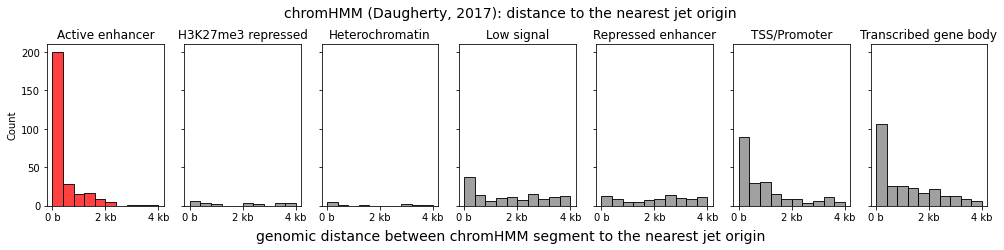

In [5]:
#C = ['black','grey','blue','green','pink','purple','magenta']
C = ['red']+['grey']*6
L = sorted(chromHMM_D['name'].unique())
t = D

bigFont = 14
f, axs = plt.subplots(
    figsize=(14, 3),
    nrows=1,
    ncols=7,
    sharey='row',
    sharex='row'
)



for i in range(len(t)):
    t_i = t[i]
    t_i_sub = t_i[t_i['distance']<=4_000]
    sns.histplot(t_i_sub['distance'],ax=axs[i],color=C[i],stat='count',fill=True,binwidth=400)
    axs[i].set_title(label=L[i])
    axs[i].set_xlabel('')
    
    format_ticks(axs[i],y=False,rotate=False)
f.text(0.51, 1, 'chromHMM (Daugherty, 2017): distance to the nearest jet origin', ha='center',fontsize=bigFont)

f.text(0.51, -0.03, 'genomic distance between chromHMM segment to the nearest jet origin', ha='center',fontsize=bigFont)

plt.tight_layout()

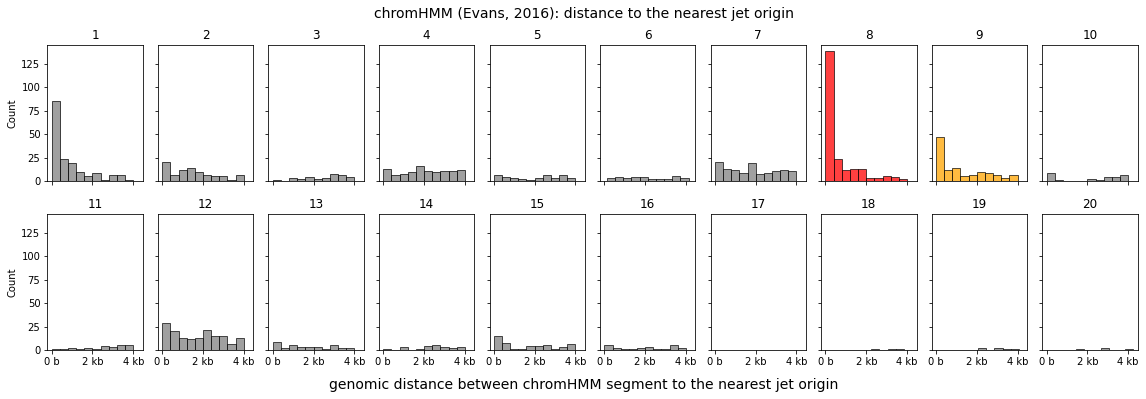

In [6]:
C = ['grey']*7+['red','orange']+['grey']*11
L = sorted(chromHMM_E['name'].unique())
t = E

f, axs = plt.subplots(
    figsize=(16, 5),
    nrows=2,
    ncols=len(L)//2,
    sharey=True,
    sharex=True
)

for i in range(0,10):
    t_i = t[i]
    t_i_sub = t_i[t_i['distance']<=4000]
    ax = sns.histplot(t_i_sub['distance'],ax=axs[0,i],color=C[i],stat='count',binwidth=400,fill=True)
    ax.set_title(label=L[i])
    ax.set_xlabel('')
    format_ticks(ax,y=False,rotate=False)

for i in range(10,20):
    t_i = t[i]
    t_i_sub = t_i[t_i['distance']<=4000]
    ax = sns.histplot(t_i_sub['distance'],ax=axs[1,i-10],color=C[i],stat='count',binwidth=400,fill=True)
    ax.set_title(label=L[i])
    ax.set_xlabel('')
    format_ticks(ax,y=False,rotate=False)
    
    
    
f.text(0.51, 1, 'chromHMM (Evans, 2016): distance to the nearest jet origin', ha='center',fontsize=bigFont)
f.text(0.51, -0.03, 'genomic distance between chromHMM segment to the nearest jet origin', ha='center',fontsize=bigFont)

plt.tight_layout()